# Testing Functionality for Project

Step 1: generate a random network

In [1]:
using Pkg
Pkg.activate("../")
using NeuralVerification

 Activating environment at `~/Dropbox/aa275Project/Project.toml`


In [2]:
import NeuralVerification: Network, Layer, ReLU, Id, affine_map, forward_partition
using LazySets

In [3]:
# construct simple network
W1 = rand(3,3)
b1 = rand(3)
L1 = Layer(W1, b1, ReLU())
W2 = rand(1,3)
b2 = rand(1)
L2 = Layer(W2, b2, Id())
network = Network([L1, L2])

Network(Layer[Layer{ReLU,Float64}([0.8993988224805334 0.08187384565860722 0.977853551061638; 0.6476466126374711 0.5479946714859152 0.14063550941420022; 0.22237329291289165 0.04177258549816765 0.018447789898065947], [0.11159246349453156, 0.24044636468756408, 0.8042391570634901], ReLU()), Layer{Id,Float64}([0.013401882910364149 0.8700004179481005 0.5626162901563636], [0.44708356807089467], Id())])

In [4]:
using Flux
flux_net = Flux.Chain(network)

Chain(Dense(3, 3, relu), Dense(3, 1))

### Step 2: simulate network to roughly estimate input/output sets

In [5]:
inputs = []
outputs = []
for i = 1:1000
    input = rand(3)
    push!(inputs, input)
    push!(outputs, flux_net(rand(3))[1])
end

In [6]:
maximum(outputs)

2.4044372645114267

In [7]:
minimum(outputs)

1.1948653330161612

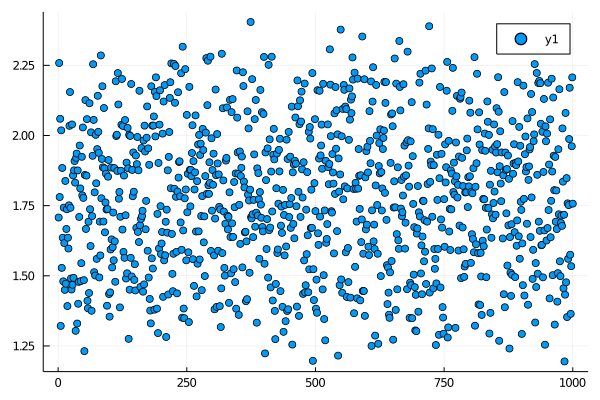

In [8]:
using Plots
Plots.scatter(outputs)

### Step 3: Calculate robustness around input of (0.5, 0.5, 0.5)

In [14]:
import LazySets: HalfSpace
import NeuralVerification: Model, init_vars, get_bounds, add_set_constraint!, add_complementary_set_constraint!, max_disturbance!, BoundedMixedIntegerLP, encode_network!

# the output set Y is [floor(minimum(outputs)), ceil(maximum(outputs))]
# meaning the complement Yc (in the simplest encoding) is nonconvex
# boundary 1 of Y: z <= ceil(maximum(outputs))
output1 = HalfSpace([1.], ceil(maximum(outputs)))
println("max bound of Y is: ", ceil(maximum(outputs)))
# have to encode each halfspace of output as separate query

# "training point" around which to find robustness
input_center = [0.5,0.5,0.5]

input_for_bounds = Hyperrectangle(low=[-1,-1,-1], high = [2,2,2])

function setup_problem(network, input_for_bounds)
    solver = MIPVerify()
    model = Model(solver)
    z = init_vars(model, network, :z, with_input=true)
    δ = init_vars(model, network, :δ, binary=true)
    # get the pre-activation bounds:
    # call ai2 get_bounds to get tighter / faster bounds that the interval arithmetic bounds that are standard with MIPVerify in this implementation
    # call planet if want tighter and slower (pass ai2 bounds as starting bounds)
    model[:bounds] = get_bounds(network, input_for_bounds, before_act=true)
    model[:before_act] = true

    return model, z
end
model, z = setup_problem(network, input_for_bounds)

# add constraints
# this is the set that the bounds are valid for: 
add_set_constraint!(model, input_for_bounds, first(z))
# y not in Y (pass Y tho)
add_complementary_set_constraint!(model, output1, last(z))
encode_network!(model, network, BoundedMixedIntegerLP())
# set objective
o = max_disturbance!(model, first(z) - input_center)

max bound of Y is: 3.0


aux_inf1

In [15]:
# solve!
using JuMP
import JuMP: optimize!
optimize!(model)

In [16]:
import JuMP: termination_status
import NeuralVerification: OPTIMAL, value
# possible outcomes:
# 1) infeasible. This means that the distance to the closest adversarial example is farther than the set input_for_bounds allows. Recourse: make the input_for_bounds set larger, try again
if termination_status(model) != OPTIMAL 
    println("Try again with larger input set")

else # if optimal! 
# 2) optimal. This means that the distance to the closest adversarial example has been found! See what it is. 
    println("The distance to the closest adversarial example is: ", value(o))
end


The distance to the closest adversarial example is: 0.9020934592893098


In [17]:
flux_net([0.5, 0.5, 0.5] .+ value(o) .- 1e-3)

1-element Array{Float64,1}:
 2.998652190849646

In [20]:
robust_bound_1 = value(o) # save this value for use in the next query

0.9020934592893098

### In a real experiment setting, I'd then do the other direction: 
Find distance to closest adversarial example for second output constraint. 
And then I'd take the minimum to find the closest distance to ANY adversarial example from this input point

### Step 4: Add an input and output to the network : the ranging sensor that I am fusing in and the fusion of the network output and the ranging sensor

In [18]:
# create new jump variable representing the new input and Expr? representing fused output, to be the new "output" of the fused network
import JuMP: @variable, set_name
# new input
new_input = @variable(model)
set_name(new_input, "new_input")
# fused output
fused_output = 0.5*last(z)[1] + 0.5*new_input

0.5 z2[1] + 0.5 new_input

### Step 5 Compute the robust set over the new input
Fixing the robust set found for the old inputs and using the same output set

First things first, the new input will be in [ 0,2 ]
And we will re-create the problem because we want new constraints and I'm not sure how to remove constraints.

In [27]:
import NeuralVerification: symbolic_infty_norm

# we will use the same output constraint, but now it will be applied to the fused output
output1 = HalfSpace([1.], ceil(maximum(outputs)))

input_for_bounds = Hyperrectangle(low=[-1,-1,-1], high = [2,2,2]) # just for re-encoding the network
model, z = setup_problem(network, input_for_bounds)

###### add new input and fused output
new_input = @variable(model)
set_name(new_input, "new_input")
# fused output
fused_output = @variable(model)
set_name(fused_output, "fused_output")
@constraint(model, fused_output == 0.5*last(z)[1] + 0.5*new_input)


# add constraints
###### OLD INPUTS
# this is the set that the bounds are valid for: 
add_set_constraint!(model, input_for_bounds, first(z)) # OG inputs for the network
# and now add constraint corresponding to robust set that was calculated
# first construct expression representing infinity norm over old inputs
o = symbolic_infty_norm(first(z) - input_center)
@constraint(model, o <= robust_bound_1) # last set value from last robustness query). 
# basically we are saying that the infinity norm of the old inputs has to be less than or 
# equal to this, which imposes constraints on the old inputs

###### OUPUTS
# y not in Y (pass Y tho)
# next add the output constraint to the FUSED SIGNAL not the old outputs (last(z))
add_complementary_set_constraint!(model, output1, [fused_output])
encode_network!(model, network, BoundedMixedIntegerLP())

###### OBJECTIVE
# set objective. Now we are setting the objective on the new_input
new_input_center = 1.
o_new = max_disturbance!(model, [new_input - new_input_center])

aux_inf2

In [28]:
# solve!
using JuMP
import JuMP: optimize!
optimize!(model)

In [31]:
import JuMP: termination_status
import NeuralVerification: OPTIMAL, value
# possible outcomes:
# 1) infeasible. No perturbation on the second sensor could cause the fused signal to leave the set Y. Are things fused correctly? Because this seems unlikely. 
if termination_status(model) != OPTIMAL 
    println("The second signal cannot break the fused signal....something is probably wrong.")

else # if optimal! 
# 2) optimal. This means that the distance to the closest adversarial example has been found! See what it is. 
    println("The distance to the closest adversarial example is: ", value(o_new))
    if value(o_new) < 1e-6
        println("The value of the objective is essentially 0, meaning that fusion strictly degrades the signal :/ Get a better second sensor?")
    else 
        println("If the signal is more precise than ", value(o_new), " it will improve the robustness of the network")
    end
end

The distance to the closest adversarial example is: 1.9999999999999996
If the signal is more precise than 1.9999999999999996 it will improve the robustness of the network


In [35]:
# evaluate the result for sanity
0.5*flux_net(input_center .+ value(o) .- 1e-3)[1] + 0.5*(new_input_center + value(o_new) - 1e-3)

2.998826095424823

## Part 6: How does robustness of the network change as the set for the fused signal gets tighter?

In [36]:
new_input_radius = value(o_new)/2

0.9999999999999998

In [44]:
# we will use the same output constraint, but now it will be applied to the fused output
output1 = HalfSpace([1.], ceil(maximum(outputs)))

input_for_bounds = Hyperrectangle(low=[-1,-1,-1], high = [3,3,3]) # just for re-encoding the network
model, z = setup_problem(network, input_for_bounds)

###### add new input and fused output
new_input = @variable(model)
set_name(new_input, "new_input")
# and now bound new_input!
smaller_new_input_bound = Hyperrectangle([new_input_center], [new_input_radius])
add_set_constraint!(model, smaller_new_input_bound, [new_input])

# fused output
fused_output = @variable(model)
set_name(fused_output, "fused_output")
@constraint(model, fused_output == 0.5*last(z)[1] + 0.5*new_input)


# add constraints
###### OLD INPUTS
# this is the set that the bounds are valid for: 
add_set_constraint!(model, input_for_bounds, first(z)) # OG inputs for the network

###### OUPUTS
# y not in Y (pass Y tho)
# next add the output constraint to the FUSED SIGNAL not the old outputs (last(z))
add_complementary_set_constraint!(model, output1, [fused_output])
encode_network!(model, network, BoundedMixedIntegerLP())

###### OBJECTIVE
# set objective. Now we are setting the objective on the OLD input to see how 
# robustness has changed
o_old_2 = max_disturbance!(model, first(z) - input_center)

aux_inf1

In [45]:
# solve!
using JuMP
import JuMP: optimize!
optimize!(model)

In [46]:
import JuMP: termination_status
import NeuralVerification: OPTIMAL, value
# possible outcomes:
# 1) infeasible. This means that the distance to the closest adversarial example is farther 
# than the set input_for_bounds allows. Recourse: make the input_for_bounds set larger, 
# try again
if termination_status(model) != OPTIMAL 
    println("Try again with larger input set")

else # if optimal! 
# 2) optimal. This means that the distance to the closest adversarial example has been found! See what it is. 
    println("The distance to the closest adversarial example is: ", value(o_old_2))
end

The distance to the closest adversarial example is: 1.6440382663395035
